In [1]:
import gym
import numpy as np
import random
from collections import defaultdict
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Blackjack-v0')

<H1>Часть первая, с блекджеком и стратегиями</H1>

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
def estimate_return_simple(env, n_episodes=200000):
    rewards = 0.

    for i in range(n_episodes):
        s = env.reset()
        while True:
            a = 0 if s[0] > 18 else 1
            s, r, done, info = env.step(a)
            if done:
                rewards += r
                break

    return rewards / n_episodes

estimate_return_simple(env)

-0.200415

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [4]:
def sample_action(env, Q, s, eps=None):
    # select action in greedy manner if eps is not None
    return random.choice(range(env.action_space.n)) \
        if s not in Q or (eps and random.random() < eps) \
        else np.argmax(Q[s])

def compute_policy_by_Q(Q):
    return {k: np.argmax(v) for k, v in Q.items()}

def estimate_return(pi, env, n_episodes=200000):
    rewards = 0.

    for i in range(n_episodes):
        s = env.reset()
        while True:
            a = random.choice(range(env.action_space.n)) if s not in pi else pi[s]
            s, r, done, info = env.step(a)
            if done:
                rewards += r
                break

    return rewards / n_episodes

In [5]:
def q_learning(env, n_episodes=500000, eps=0.01, gamma=1., alpha=0.05):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []
    
    for i in range(n_episodes):
        if i % 50000 == 0:
            pi = compute_policy_by_Q(Q)
            rewards.append(estimate_return(pi, env))
            
        s = env.reset()
        
        while True:
            a = sample_action(env, Q, s, eps)

            s_prime, r, done, info = env.step(a)
            
            Q[s][a] += alpha * (r + gamma * max(Q[s_prime]) - Q[s][a])
                
            s = s_prime
            
            if done:
                break
    
    return Q, rewards

In [6]:
Q, rewards = q_learning(env)
pi = compute_policy_by_Q(Q)
estimate_return(pi, env)

-0.130545

4. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

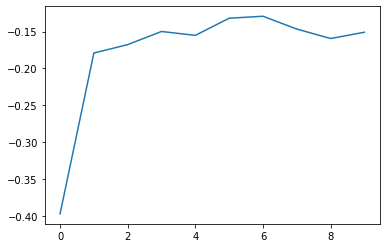

In [7]:
plt.plot(rewards)

<H1>Часть вторая, удвоенная</H1>

double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [15]:
from gym.envs.toy_text.blackjack import draw_hand, sum_hand, usable_ace, is_bust, cmp, draw_card, score

class BlackjackDoubleEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double
            self.player.append(draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
                if self.natural and is_natural(self.player) and reward == 2.:
                    reward = 3.
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [9]:
env = BlackjackDoubleEnv()
Q, rewards = q_learning(env)
pi = compute_policy_by_Q(Q)
estimate_return(pi, env)

-0.239955

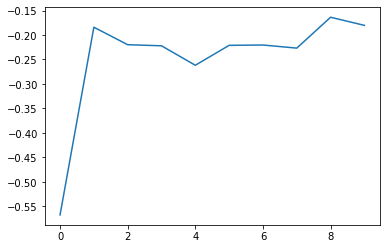

In [10]:
plt.plot(rewards)

<H1>Часть третья, в главной роли — Дастин Хоффман</H1>

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [18]:
# https://en.wikipedia.org/wiki/Card_counting
halves = [0.5, 1., 1., 1.5, 1., 0.5, 0., -0.5, -1., -1., -1., -1.]

class BlackjackCountEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def draw_card(self):
        result = self.deck[self.position]
        self.position += 1
        self.drawn_cards_sum += halves[result - 1]
        return result
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]    
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double
            self.player.append(self.draw_card())
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                reward = cmp(score(self.player), score(self.dealer)) * 2
                if self.natural and is_natural(self.player) and reward == 2.:
                    reward = 3.
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        if done:
            if (len(self.deck) - self.position < 15):
                self.shuffle_deck()
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], self.drawn_cards_sum,
                usable_ace(self.player))
    
    def shuffle_deck(self):
        random.shuffle(self.deck)
        self.drawn_cards_sum = 0.
        self.position = 0

    def reset(self):
        self.deck = (list(range(10)) + [10] * 4) * 4
        self.shuffle_deck() 
        self.dealer = [self.draw_card()]
        self.player = self.draw_hand()
        return self._get_obs()

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [19]:
env = BlackjackCountEnv()
Q, rewards = q_learning(env)
pi = compute_policy_by_Q(Q)
estimate_return(pi, env)

-0.12584

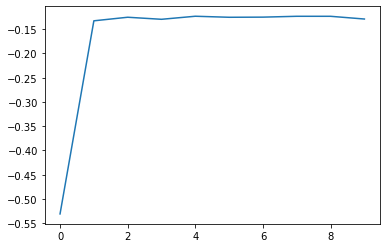

In [20]:
plt.plot(rewards)